# Logistic Regression From Scratch

# 📦 Imports

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore')

# 📥 Load the dataset


In [60]:
data = pd.read_csv("/kaggle/input/churn-modelling/Churn_Modelling .csv")

# 🧹 Data Preprocessing


In [61]:
def preprocess_data(data):
    # Drop unnecessary columns
    data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
    
    # Handle missing values
    data = data.dropna()
    
    # Convert categorical variables to numerical
    data['Geography'] = data['Geography'].map({'France': 0, 'Germany': 1, 'Spain': 2})
    data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})
    
    return data

# Preprocess the data
processed_data = preprocess_data(data)

# 📊 Correlation Analysis


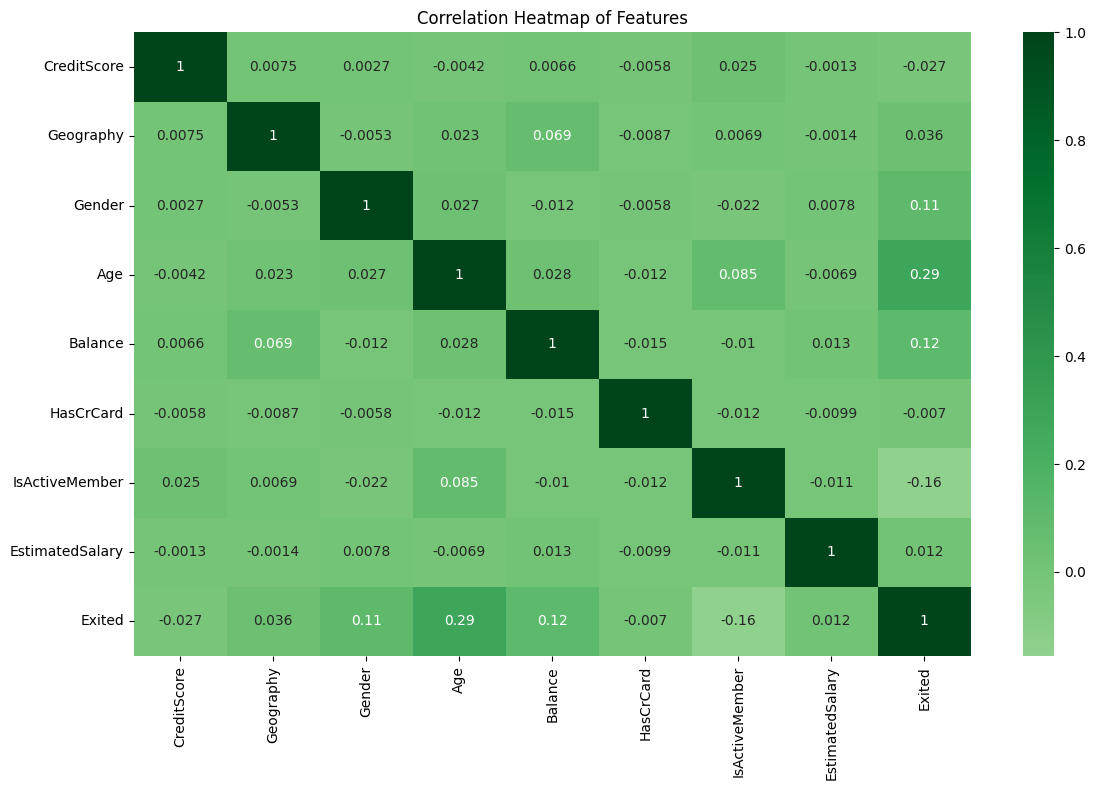

In [62]:
plt.figure(figsize=(12, 8))
correlation_matrix = processed_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', center=0)
plt.title('Correlation Heatmap of Features')
plt.tight_layout()
plt.show()

# 📈 Pairplot for Selected Features


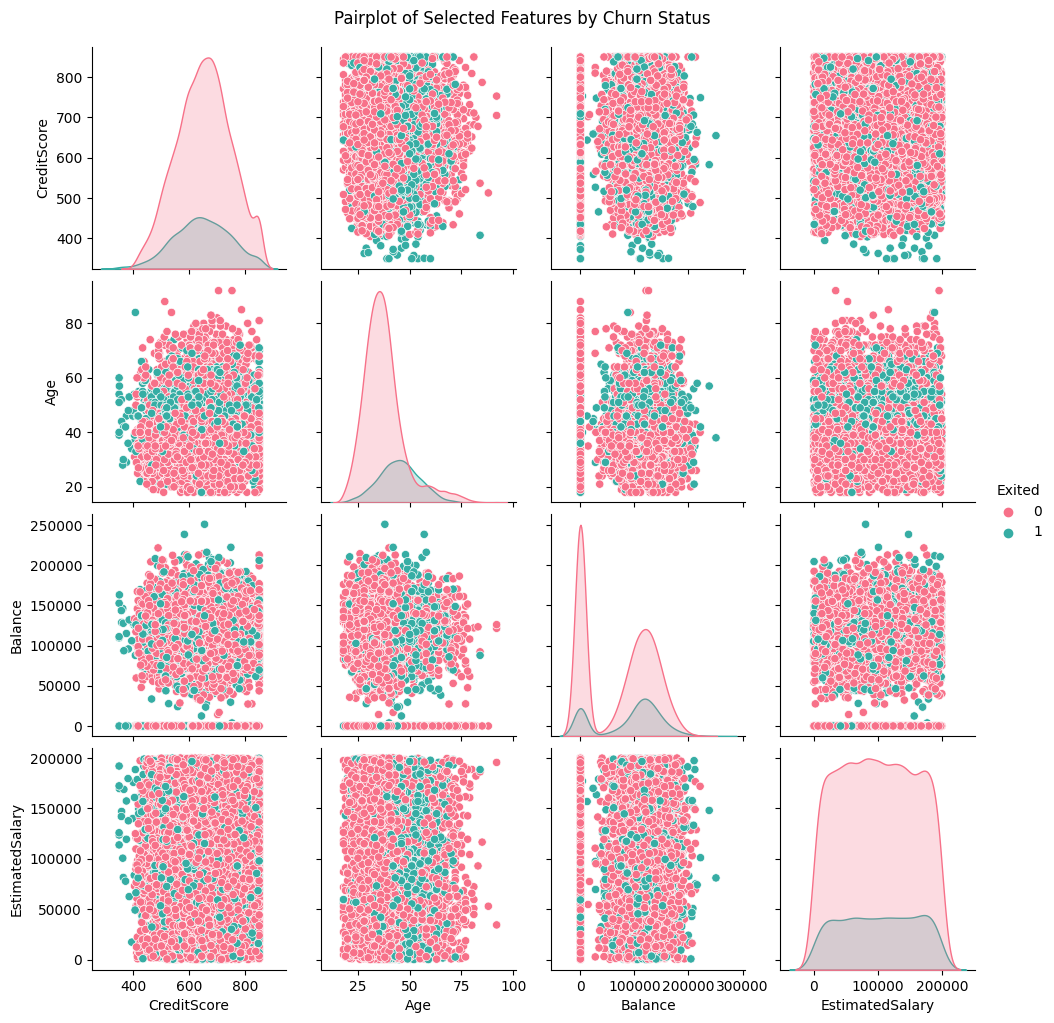

In [63]:
sns.pairplot(processed_data[['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Exited']], 
             hue='Exited', diag_kind='kde', palette='husl')
plt.suptitle('Pairplot of Selected Features by Churn Status', y=1.02)
plt.show()

# 📦 Distribution of Features by Churn Status


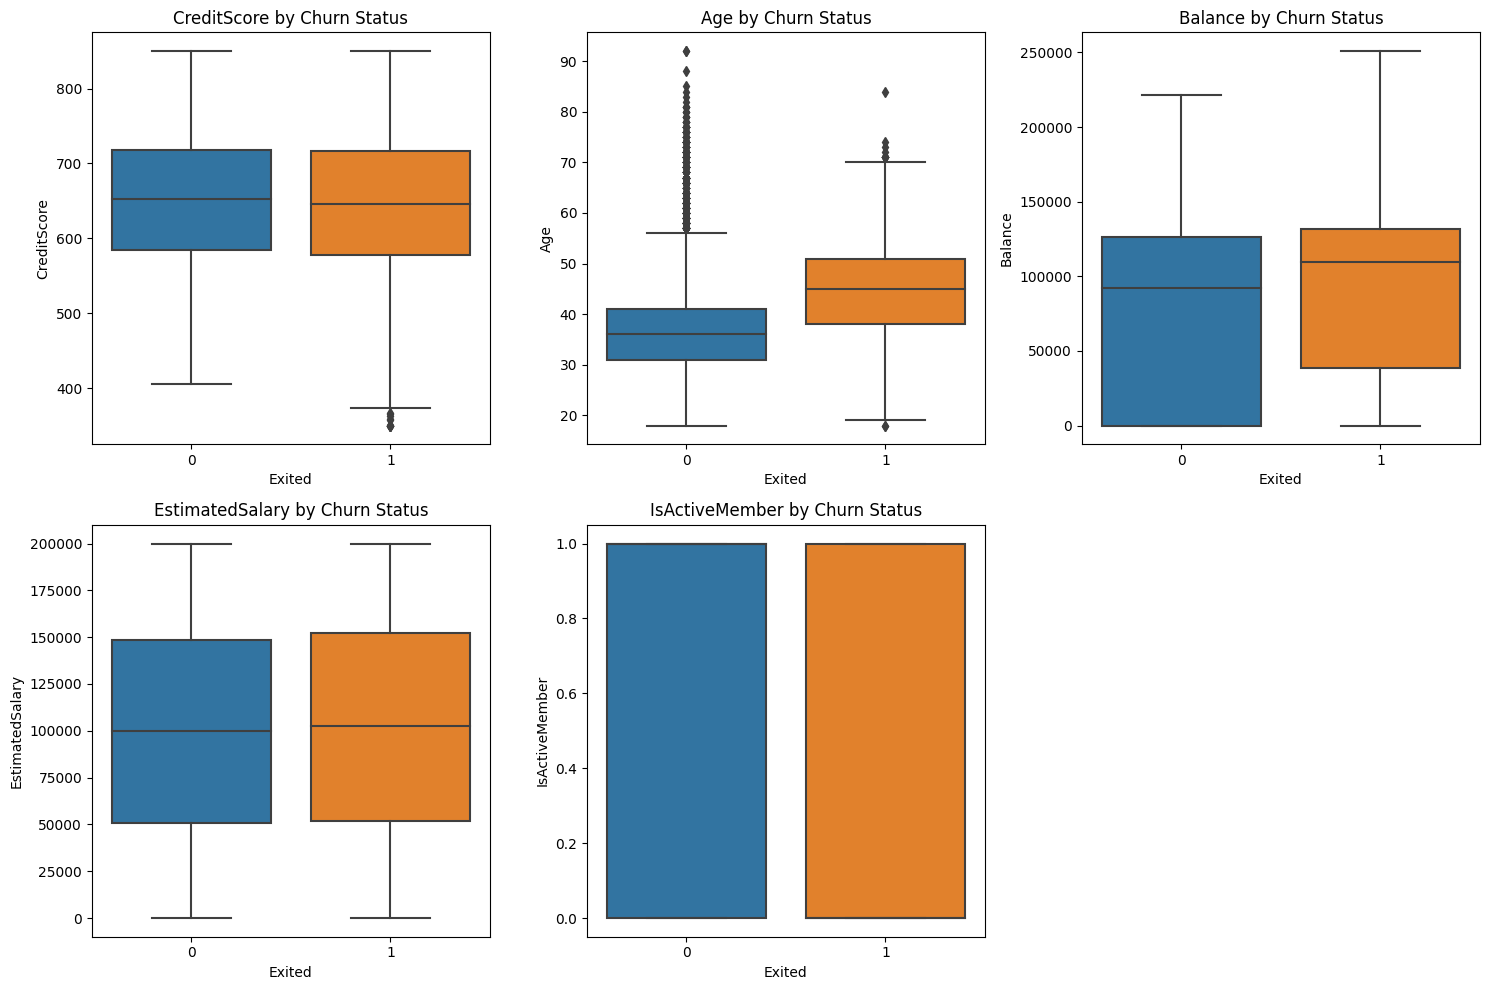

In [64]:
plt.figure(figsize=(15, 10))
features_to_plot = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'IsActiveMember']
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Exited', y=feature, data=processed_data)
    plt.title(f'{feature} by Churn Status')
plt.tight_layout()
plt.show()

# 🧾 Feature/Target Separation and Scaling


In [65]:
X = processed_data.drop('Exited', axis=1).values
y = processed_data['Exited'].values

# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Add bias term
X = np.hstack([np.ones((X.shape[0], 1)), X])


# 🧪 Train/Test Split


In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14, stratify=y)

# 🧠 Sigmoid Function


In [67]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# 🏗️ Logistic Regression from Scratch (Class Definition)


In [68]:
class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.05, n_iterations=3000, lambda_=0.01, batch_size=None):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.lambda_ = lambda_
        self.batch_size = batch_size
        self.weights = None
        self.bias = None
        self.loss_history = []
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for i in range(self.n_iterations):
            if self.batch_size is None:
                linear_model = np.dot(X, self.weights) + self.bias
                y_pred = sigmoid(linear_model)
                
                dw = (1/n_samples) * np.dot(X.T, (y_pred - y)) + (self.lambda_/n_samples) * self.weights
                db = (1/n_samples) * np.sum(y_pred - y)
                
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
                
                loss = self.compute_loss(X, y)
                self.loss_history.append(loss)
                
            else:
                indices = np.random.permutation(n_samples)
                X_shuffled = X[indices]
                y_shuffled = y[indices]
                
                for j in range(0, n_samples, self.batch_size):
                    X_batch = X_shuffled[j:j+self.batch_size]
                    y_batch = y_shuffled[j:j+self.batch_size]
                    batch_size = len(y_batch)
                    
                    linear_model = np.dot(X_batch, self.weights) + self.bias
                    y_pred = sigmoid(linear_model)
                    
                    dw = (1/batch_size) * np.dot(X_batch.T, (y_pred - y_batch)) + (self.lambda_/batch_size) * self.weights
                    db = (1/batch_size) * np.sum(y_pred - y_batch)
                    
                    self.weights -= self.learning_rate * dw
                    self.bias -= self.learning_rate * db
                
                loss = self.compute_loss(X, y)
                self.loss_history.append(loss)
    
    def compute_loss(self, X, y):
        n_samples = len(y)
        linear_model = np.dot(X, self.weights) + self.bias
        y_pred = sigmoid(linear_model)
        
        loss = (-1/n_samples) * np.sum(y * np.log(y_pred + 1e-15) + (1-y) * np.log(1-y_pred + 1e-15))
        reg_loss = (self.lambda_/(2*n_samples)) * np.sum(self.weights[1:]**2)
        return loss + reg_loss
    
    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return sigmoid(linear_model)
    
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

# 🏋️ Train Models with Different Gradient Descent Approaches


In [80]:
models = {
    "Batch GD": LogisticRegressionScratch(learning_rate=0.05, n_iterations=3000, lambda_=0.01),
    "Stochastic GD": LogisticRegressionScratch(learning_rate=0.005, n_iterations=5000, lambda_=0.01, batch_size=1),
    "Mini-batch GD": LogisticRegressionScratch(learning_rate=0.02, n_iterations=2000, lambda_=0.01, batch_size=64)
}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)


Training Batch GD...
Training Stochastic GD...
Training Mini-batch GD...


# ⚙️ Train scikit-learn Logistic Regression Model


In [81]:
sklearn_lr = LogisticRegression(penalty='l2', C=1/0.01, solver='liblinear', max_iter=5000)
sklearn_lr.fit(X_train, y_train)


LogisticRegression(C=100.0, max_iter=5000, solver='liblinear')

# 📉 Plot Training Loss Curves


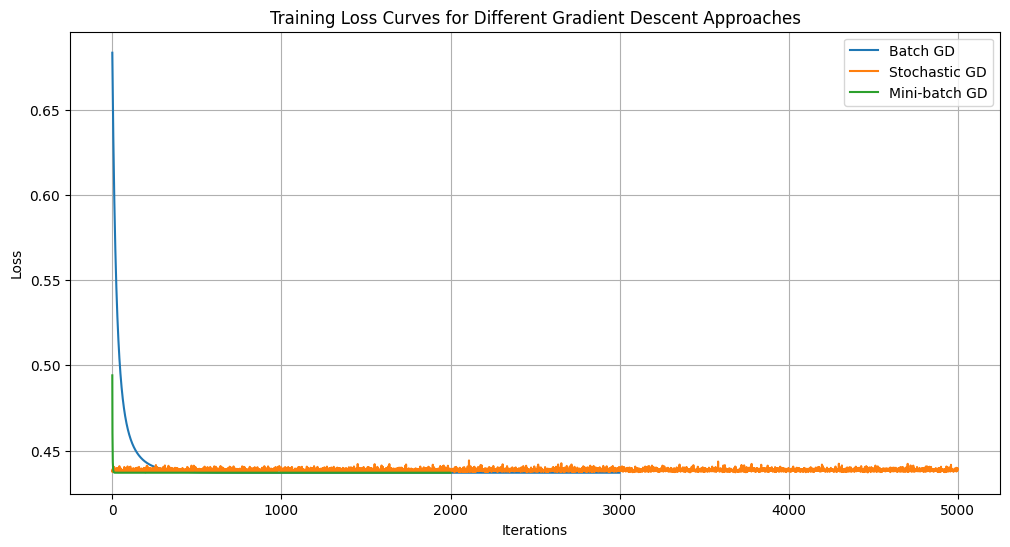

In [82]:
plt.figure(figsize=(12, 6))
for name, model in models.items():
    plt.plot(range(len(model.loss_history)), model.loss_history, label=name)

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Curves for Different Gradient Descent Approaches')
plt.legend()
plt.grid(True)
plt.show()


# 🧪 Model Evaluation Function with Optimal Threshold

In [83]:
def evaluate_model(model, X_test, y_test, name):
    y_proba = model.predict_proba(X_test)
    
    # Find optimal threshold
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    y_pred = (y_proba >= optimal_threshold).astype(int)
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{name} Model Evaluation:")
    print(f"Accuracy: {accuracy:.4f} (using threshold={optimal_threshold:.4f})")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # ROC Curve
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()
    
    return accuracy


# 📊 Evaluate Scikit-learn Model


Evaluating: Batch GD

Batch GD Model Evaluation:
Accuracy: 0.6975 (using threshold=0.2039)

Confusion Matrix:
[[1092  500]
 [ 105  303]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.69      0.78      1592
           1       0.38      0.74      0.50       408

    accuracy                           0.70      2000
   macro avg       0.64      0.71      0.64      2000
weighted avg       0.80      0.70      0.73      2000



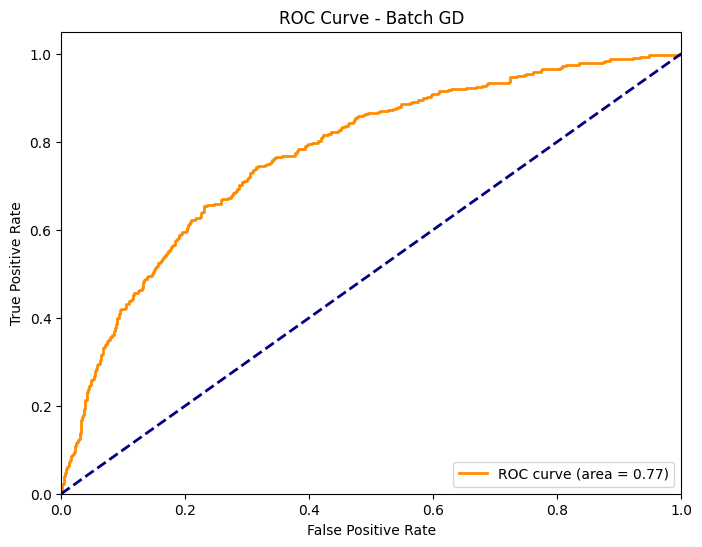

Evaluating: Stochastic GD

Stochastic GD Model Evaluation:
Accuracy: 0.7230 (using threshold=0.2142)

Confusion Matrix:
[[1164  428]
 [ 126  282]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1592
           1       0.40      0.69      0.50       408

    accuracy                           0.72      2000
   macro avg       0.65      0.71      0.66      2000
weighted avg       0.80      0.72      0.75      2000



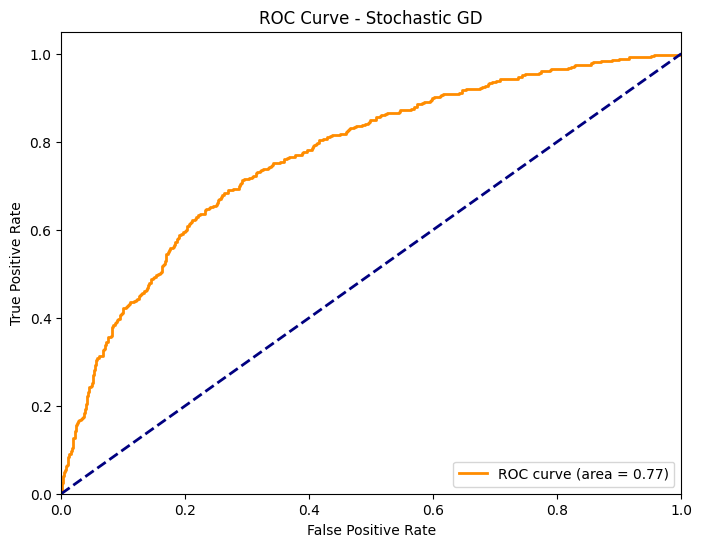

Evaluating: Mini-batch GD

Mini-batch GD Model Evaluation:
Accuracy: 0.6955 (using threshold=0.2030)

Confusion Matrix:
[[1087  505]
 [ 104  304]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.68      0.78      1592
           1       0.38      0.75      0.50       408

    accuracy                           0.70      2000
   macro avg       0.64      0.71      0.64      2000
weighted avg       0.80      0.70      0.72      2000



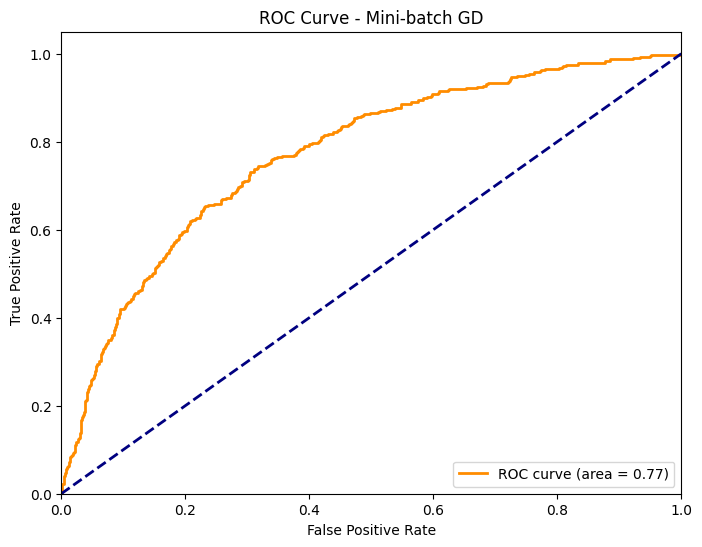


Scikit-learn Logistic Regression Evaluation:
Accuracy: 0.6975 (using threshold=0.2039)


In [84]:
accuracies = {}
for name, model in models.items():
    print(f"Evaluating: {name}")  # 👈 Add this
    accuracies[name] = evaluate_model(model, X_test, y_test, name)

# 📊 Evaluate Scikit-learn Model (moved outside loop)
y_proba_sklearn = sklearn_lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba_sklearn)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_sklearn = (y_proba_sklearn >= optimal_threshold).astype(int)
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)

print("\nScikit-learn Logistic Regression Evaluation:")
print(f"Accuracy: {accuracy_sklearn:.4f} (using threshold={optimal_threshold:.4f})")

# 📊 Compare Model Accuracies


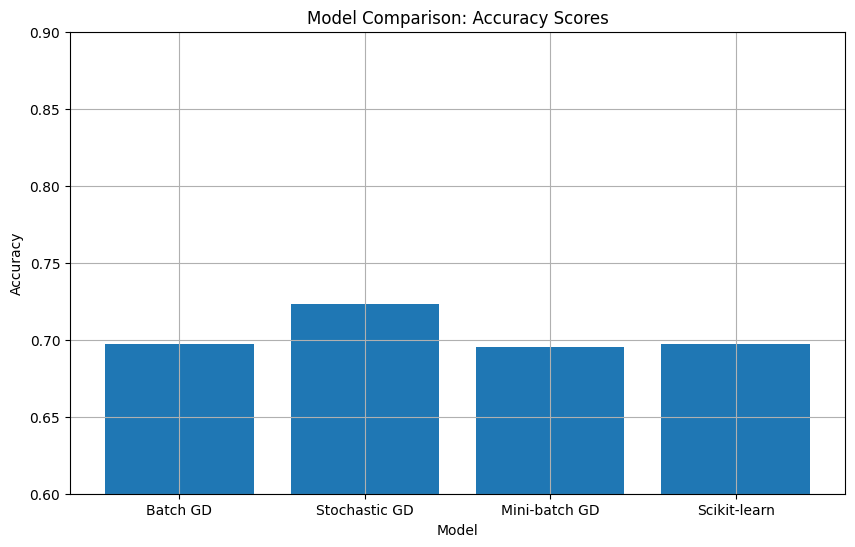

In [85]:
plt.figure(figsize=(10, 6))
plt.bar(list(accuracies.keys()) + ['Scikit-learn'], list(accuracies.values()) + [accuracy_sklearn])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison: Accuracy Scores')
plt.ylim(0.6, 0.9) 
plt.grid(True)
plt.show()


# 📌 Feature Importance Visualization (Batch GD)


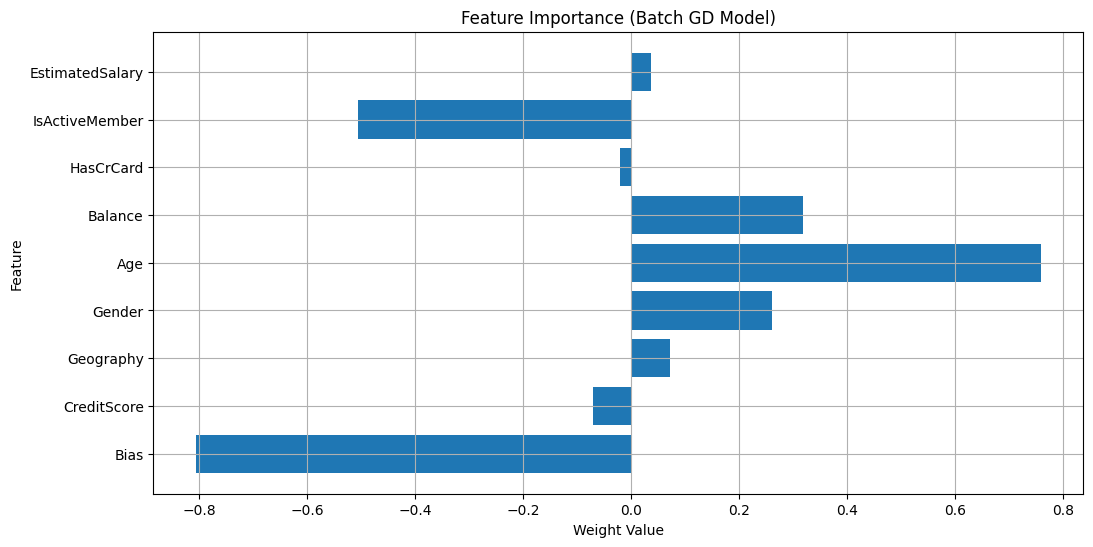

In [86]:
feature_names = ['Bias'] + list(processed_data.drop('Exited', axis=1).columns)
weights = models["Batch GD"].weights

plt.figure(figsize=(12, 6))
plt.barh(feature_names, weights)
plt.xlabel('Weight Value')
plt.ylabel('Feature')
plt.title('Feature Importance (Batch GD Model)')
plt.grid(True)
plt.show()
